# Dataset


https://www.kaggle.com/datasets/researcher1548/livestock-symptoms-and-diseases

# Import libraries and load the dataset

In [165]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import pickle

In [167]:
file_path = '/content/drive/MyDrive/THESIS/Datasets-20240427T172951Z-001/Datasets/cattle-disease-dataset-main.csv'
data = pd.read_csv(file_path)

In [168]:
data.head(5)

,Animal,Age,Temperature,Symptom 1,Symptom 2,Symptom 3,Disease
0,cow,3,103.1,depression,painless lumps,loss of appetite,pneumonia
1,buffalo,13,104.5,painless lumps,loss of appetite,depression,lumpy virus
2,sheep,1,100.5,depression,painless lumps,loss of appetite,lumpy virus
3,cow,14,100.3,loss of appetite,swelling in limb,crackling sound,blackleg
4,sheep,2,103.6,painless lumps,loss of appetite,depression,pneumonia


In [169]:
print(f"Pneumonia: {(data['Disease'] == 'pneumonia').sum()}")
print(f"Blackleg: {(data['Disease'] == 'blackleg').sum()}")
print(f"Foot and Mouth: {(data['Disease'] == 'foot and mouth').sum()}")
print(f"Anthrax: {(data['Disease'] == 'anthrax').sum()}")
print(f"Lumpy Virus: {(data['Disease'] == 'lumpy virus').sum()}")

Pneumonia: 7330
Blackleg: 9713
Foot and Mouth: 9701
Anthrax: 9842
Lumpy Virus: 7192


In [170]:
print(data.shape)
print(data.info())
print(data.describe().T)

(43778, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43778 entries, 0 to 43777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Animal       43778 non-null  object 
 1   Age          43778 non-null  int64  
 2   Temperature  43778 non-null  float64
 3   Symptom 1    43778 non-null  object 
 4   Symptom 2    43778 non-null  object 
 5   Symptom 3    43778 non-null  object 
 6   Disease      43778 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.3+ MB
None
               count        mean       std    min    25%    50%    75%    max
Age          43778.0    6.769131  3.886739    1.0    4.0    7.0   10.0   15.0
Temperature  43778.0  102.269590  1.400872  100.0  101.1  102.2  103.4  105.0


In [171]:
all_animals = data['Animal'].unique()
print(f'Animals: {all_animals}\nNumber of animals = {len(all_animals)}')

all_diseases = data['Disease'].unique()
print(f'Diseases: {all_diseases}\nNumber of diseases = {len(all_diseases)}')

Animals: ['cow' 'buffalo' 'sheep' 'goat']
Number of animals = 4
Diseases: ['pneumonia' 'lumpy virus' 'blackleg' 'foot and mouth' 'anthrax']
Number of diseases = 5


In [172]:
def unique_symptoms(data):
    symptom_features = ['Symptom 1', 'Symptom 2', 'Symptom 3']
    for symptom in symptom_features:
        unique_sym = data[symptom].unique()
        print(f"{symptom}: {np.sort(unique_sym)}\nTotal = {len(unique_sym)}\n")

unique_symptoms(data)

Symptom 1: ['blisters on gums' 'blisters on hooves' 'blisters on mouth'
 'blisters on tongue' 'chest discomfort' 'chills' 'crackling sound'
 'depression' 'difficulty walking' 'fatigue' 'lameness' 'loss of appetite'
 'painless lumps' 'shortness of breath' 'sores on gums' 'sores on hooves'
 'sores on mouth' 'sores on tongue' 'sweats' 'swelling in abdomen'
 'swelling in extremities' 'swelling in limb' 'swelling in muscle'
 'swelling in neck']
Total = 24

Symptom 2: ['blisters on gums' 'blisters on hooves' 'blisters on mouth'
 'blisters on tongue' 'chest discomfort' 'chills' 'crackling sound'
 'depression' 'difficulty walking' 'fatigue' 'lameness' 'loss of appetite'
 'painless lumps' 'shortness of breath' 'sores on gums' 'sores on hooves'
 'sores on mouth' 'sores on tongue' 'sweats' 'swelling in abdomen'
 'swelling in extremities' 'swelling in limb' 'swelling in muscle'
 'swelling in neck']
Total = 24

Symptom 3: ['blisters on gums' 'blisters on hooves' 'blisters on mouth'
 'blisters on to

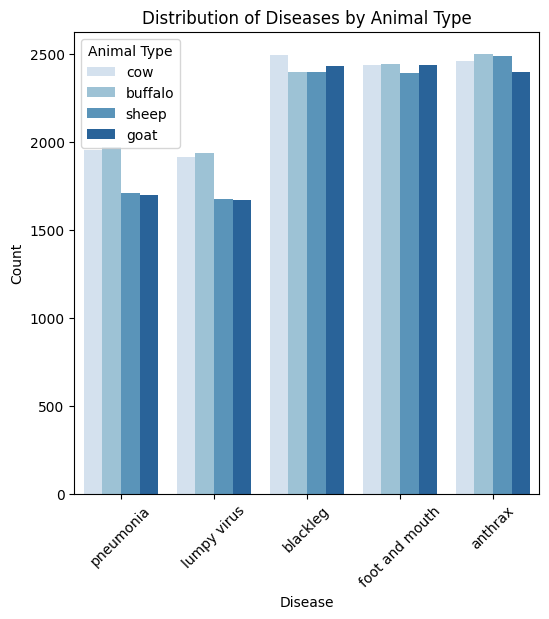

In [173]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='Disease', hue='Animal', palette='Blues')
plt.title('Distribution of Diseases by Animal Type')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Animal Type')
plt.show()

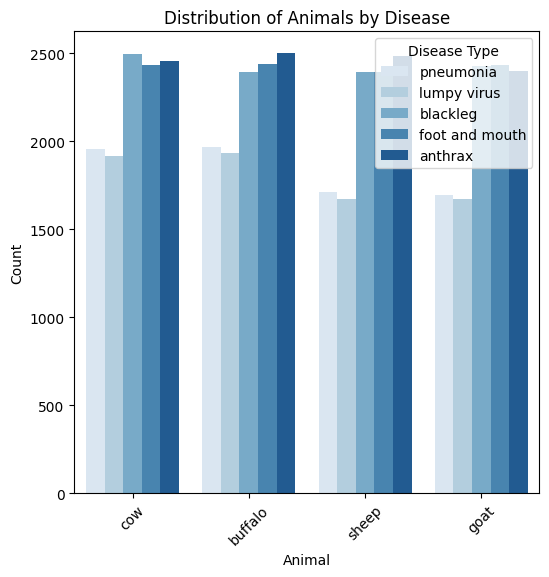

In [174]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='Animal', hue='Disease', palette='Blues')
plt.title('Distribution of Animals by Disease')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Disease Type')
plt.show()

<ipython-input-175-78e80c3c71b0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Disease', palette='Blues')


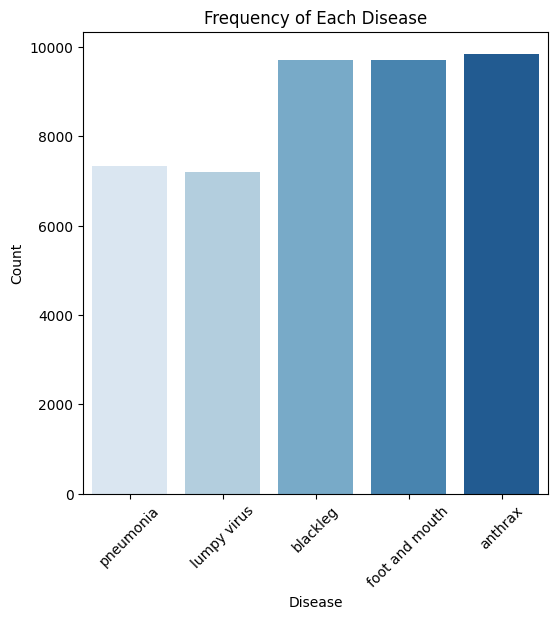

In [175]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='Disease', palette='Blues')
plt.title('Frequency of Each Disease')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Preprocessing

In [176]:
from sklearn.preprocessing import LabelEncoder

# Add a special category for unknown values
def fit_label_encoder_with_unknown(data_column):
    unique_values = list(data_column.unique()) + ["unknown"]
    encoder = LabelEncoder()
    encoder.fit(unique_values)
    return encoder

# Fit encoders for each categorical column
label_encoders = {
    "Animal": fit_label_encoder_with_unknown(data["Animal"]),
    "Temperature": fit_label_encoder_with_unknown(data["Temperature"]),
    "Symptom 1": fit_label_encoder_with_unknown(data["Symptom 1"]),
    "Symptom 2": fit_label_encoder_with_unknown(data["Symptom 2"]),
    "Symptom 3": fit_label_encoder_with_unknown(data["Symptom 3"]),
    "Disease": fit_label_encoder_with_unknown(data["Disease"])
}

In [177]:
X = data[['Animal', 'Age', 'Temperature', 'Symptom 1', 'Symptom 2', 'Symptom 3']]
y = data['Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30644, 6)
(13134, 6)
(30644,)
(13134,)


# Data Visualization

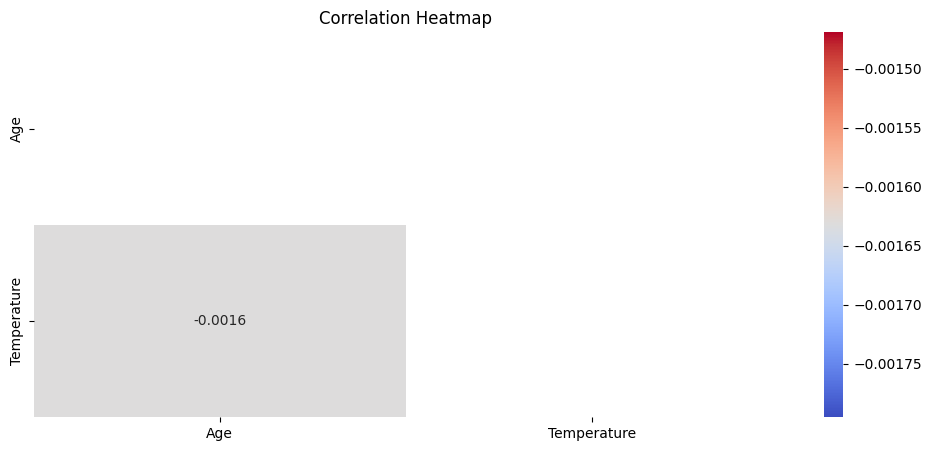

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
corr = numeric_data.corr()

# Create a mask to hide the upper triangle of the heatmap (optional)
mask = np.triu(corr)

# Plot the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True, mask=mask, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Basic Models

**XGBOOST**

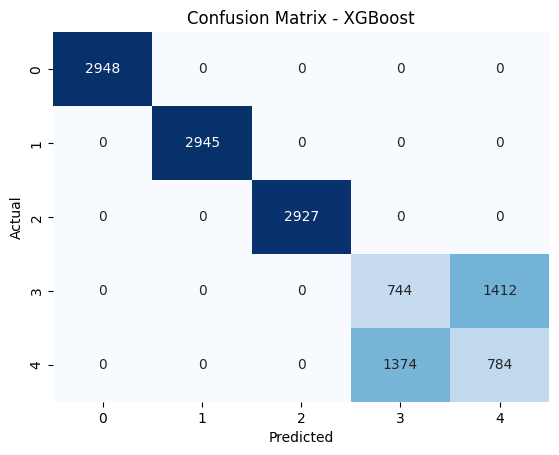

XGBoost Accuracy: 0.7878787878787878
XGBoost Precision: 0.7878621864937599
XGBoost Recall: 0.7878787878787878
XGBoost F1 Score: 0.787861461622045


In [179]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# Assuming 'data' is your DataFrame and 'Disease' is the target column

# Encode categorical columns
categorical_columns = ['Animal', 'Symptom 1', 'Symptom 2', 'Symptom 3']
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le

# Encode the target variable (Disease)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Function to train XGBoost classifier
def train_xgboost(X_train, y_train, **params):
    xgb_classifier = xgb.XGBClassifier(**params)
    xgb_classifier.fit(X_train, y_train)
    return xgb_classifier

# XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.2,
    'max_depth': 10,
    'random_state': 42,
    'eval_metric': 'logloss'
}

# Train the XGBoost classifier
xgb_classifier = train_xgboost(X_train, y_train_encoded, **xgb_params)

# Predict using the trained model
y_pred_xgb = xgb_classifier.predict(X_test)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Performance Metrics
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted')

print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost Precision: {precision_xgb}")
print(f"XGBoost Recall: {recall_xgb}")
print(f"XGBoost F1 Score: {f1_xgb}")


# SAVE MODEL

In [180]:
saved_steps = {
    'xgb_model': xgb_classifier,
    'label_encoders': label_encoders
}

with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(saved_steps, file)

#SAMPLE INPUT OUTPUT

In [181]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the saved models and encoders
with open('saved_steps.pkl', 'rb') as file:
    saved_objects = pickle.load(file)

xgb_model = saved_objects['xgb_model']
label_encoders = saved_objects['label_encoders']

# Use the disease labels from the saved objects if available
if 'disease_labels' in saved_objects:
    disease_labels = saved_objects['disease_labels']
else:
    disease_labels = ['anthrax', 'blackleg', 'foot and mouth', 'lumpy virus', 'pneumonia']  # Default fallback

disease_encoder = LabelEncoder()
disease_encoder.fit(disease_labels)

# Define a sample input
sample_data = {
    'Animal': 'sheep',
    'Age': 3,
    'Temperature': '103.0',
    'Symptom 1': 'chills',
    'Symptom 2': 'sores on hooves',
    'Symptom 3': 'sweats'
}

# Encode the sample input
def safe_transform_with_unknown(encoder, value):
    if value not in encoder.classes_:
        return -1  # Return a placeholder for unknown values
    return encoder.transform([value])[0]

encoded_input = [
    safe_transform_with_unknown(label_encoders['Animal'], sample_data['Animal']),
    sample_data['Age'],  # Age is numeric, no encoding needed
    float(sample_data['Temperature']),  # Convert Temperature to float
    safe_transform_with_unknown(label_encoders['Symptom 1'], sample_data['Symptom 1']),
    safe_transform_with_unknown(label_encoders['Symptom 2'], sample_data['Symptom 2']),
    safe_transform_with_unknown(label_encoders['Symptom 3'], sample_data['Symptom 3']),
]

# Reshape the input to fit the model
encoded_input = np.array(encoded_input).reshape(1, -1)

# Predict with XGBoost and display the disease prediction
xgb_prediction = xgb_model.predict(encoded_input)
xgb_disease = disease_encoder.inverse_transform(xgb_prediction)
print(f"Predicted Disease (XGBoost): {xgb_disease[0]}")


Predicted Disease (XGBoost): anthrax


In [182]:
# # SAMPLE INPUT
# input_arr = [['cow', 3, '103.0', 'swelling in limb', 'painful mouth', 'difficulty walking']]

# df = pd.DataFrame(input_arr, columns=['Animal', 'Age', 'Temperature','Symptom 1', 'Symptom 2', 'Symptom 3'])
# print(df)

In [183]:
# for column in ['Animal',  'Temperature','Symptom 1', 'Symptom 2', 'Symptom 3']:

#     df[column] = label_encoders[column].transform(df[column])

# print(df)

In [184]:
# # Evaluate the single input sample
# predictions = xgb_classifier.predict(df)

# d = {0:'pneumonia', 1:'lumpy virus', 2:'blackleg',3:'foot and mouth', 4:'anthrax'}

# print(d[predictions[0]])
# #print(predictions)